## CUSTOMER PERSONALITY ANALYSIS AND CUSTOMER RESPONSE PREDICTION

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

The objective of this notebook is to find valuable insights on customers behaviours, segment similar customers based on traits and finally create predictive model to predict which customers will respond to marketting campaigns.

### Dataset import and inspection

In [46]:
#Import Libraries

import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data viz
import seaborn as sns #data viz
from sklearn.impute import SimpleImputer #imputes missing vals
from sklearn.preprocessing import StandardScaler, OneHotEncoder #preprocessing
from sklearn.compose import ColumnTransformer #preprocessing
from sklearn.decomposition import PCA #dimensionality reduction
from sklearn.cluster import DBSCAN #clustering
from sklearn.model_selection import train_test_split, GridSearchCV #data split, grid search
from imblearn.over_sampling import SMOTE #balance classes
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.svm import SVC #support vector machine
from sklearn.neighbors import KNeighborsClassifier #knn
from xgboost import XGBClassifier #gradient boosting tree
from sklearn.metrics import accuracy_score, recall_score #calculates accuracy, recall
from sklearn.ensemble import VotingClassifier#ensemble

In [12]:

customer_data = pd.read_csv('Datasets/marketing_campaign.csv',
                           delimiter='\t', index_col='ID')
customer_data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,...,5,0,0,0,0,0,0,3,11,0


In [13]:
customer_data.shape

(2240, 28)


In the dataset there are attributes related to people, products, promotion and place:

People

    ID: Customer's unique identifier
    Year_Birth: Customer's birth year
    Education: Customer's education level
    Marital_Status: Customer's marital status
    Income: Customer's yearly household income
    Kidhome: Number of children in customer's household
    Teenhome: Number of teenagers in customer's household
    Dt_Customer: Date of customer's enrollment with the company
    Recency: Number of days since customer's last purchase
    Complain: 1 if customer complained in the last 2 years, 0 otherwise

Products

    MntWines: Amount spent on wine in last 2 years
    MntFruits: Amount spent on fruits in last 2 years
    MntMeatProducts: Amount spent on meat in last 2 years
    MntFishProducts: Amount spent on fish in last 2 years
    MntSweetProducts: Amount spent on sweets in last 2 years
    MntGoldProds: Amount spent on gold in last 2 years

Promotion

    NumDealsPurchases: Number of purchases made with a discount
    AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
    AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
    AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
    AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
    AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
    Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place

    NumWebPurchases: Number of purchases made through the company’s web site
    NumCatalogPurchases: Number of purchases made using a catalogue
    NumStorePurchases: Number of purchases made directly in stores
    NumWebVisitsMonth: Number of visits to company’s web site in the last month


### Data processing and feature engineering

In [14]:
#Create 'MntTotal' for total amount spent on all items
customer_data['MntTotal'] = customer_data['MntWines'].values + customer_data['MntFruits'].values + \
                            customer_data['MntMeatProducts'].values + customer_data['MntFishProducts'].values + \
                            customer_data['MntWines'].values + customer_data['MntSweetProducts'].values + \
                            customer_data['MntGoldProds'].values

#Drops the unnecessary features from the original dataset
customer_data.drop(['Dt_Customer', 'Year_Birth', 'AcceptedCmp1', 'AcceptedCmp2',
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Kidhome', 'Teenhome',
                   'Z_CostContact', 'Z_Revenue', 'Marital_Status'],
                   axis=1, inplace=True)
customer_data.head() 

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,MntTotal
ID,,,,,,,,,,,,,,,,,
5524,Graduation,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0,1,2252
2174,Graduation,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0,0,38
4141,Graduation,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,1202
6182,Graduation,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,64
5324,PhD,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,595


In [15]:
isnull_number = []
for i in customer_data.columns:
    x = customer_data[i].isnull().sum()
    isnull_number.append(x)
    
pd.DataFrame(isnull_number, index = customer_data.columns, columns = ["Total Missing Values"])

,Total Missing Values
Education,0
Income,24
Recency,0
MntWines,0
MntFruits,0
MntMeatProducts,0
MntFishProducts,0
MntSweetProducts,0
MntGoldProds,0
NumDealsPurchases,0


The 'Income' column contains 24 missing values. Since this only accounts for 1% of the total dataset, imputing the mean will not have great consequences.

In [16]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(customer_data.Income.values.reshape(-1,1))
customer_data['Income'] = imputer.transform(customer_data.Income.values.reshape(-1,1))

### Dimensionality reduction

The data will need some preprocessing before the dimensionality is reduced. 'Education' needs to be encoded and the other columns need to be scaled. Also, the target column 'Repsonse' needs to be removed from the dataset.

In [17]:
#Remove the 'Response' column because it is the target of future predictive model
X, y = customer_data.drop('Response', axis=1).values, customer_data['Response'].values

#Creates a column transformer that sends 'Education' to be encoded and rest scaled
ct = ColumnTransformer([
    ('catagoric', OneHotEncoder(), [0]),
    ('numeric', StandardScaler(), list(range(1, len(X.T))))
])

#Sends the data through the column transformer
X_transformed = ct.fit_transform(X)
print('Preprocessed Data:')
print(X_transformed[0])

Preprocessed Data:
[ 0.          0.          1.          0.          0.          0.23532677
  0.30703926  0.98378127  1.55157698  1.67970233  2.46214705  1.4765001
  0.84320691  0.34941394  1.40930394  2.51089024 -0.55078479  0.69390374
 -0.09728167  1.4669731 ]


In [18]:
pca = PCA(n_components=3) # n=3 to visualize the data better

#fit to dataset
pca.fit(X_transformed)

#create dimentionality reduced dataset
X_reduced = pca.transform(X_transformed)

print('Dimentionality Reduced Data:')
print(X_reduced[0])

Dimentionality Reduced Data:
[3.95115331 0.49542292 0.62783373]


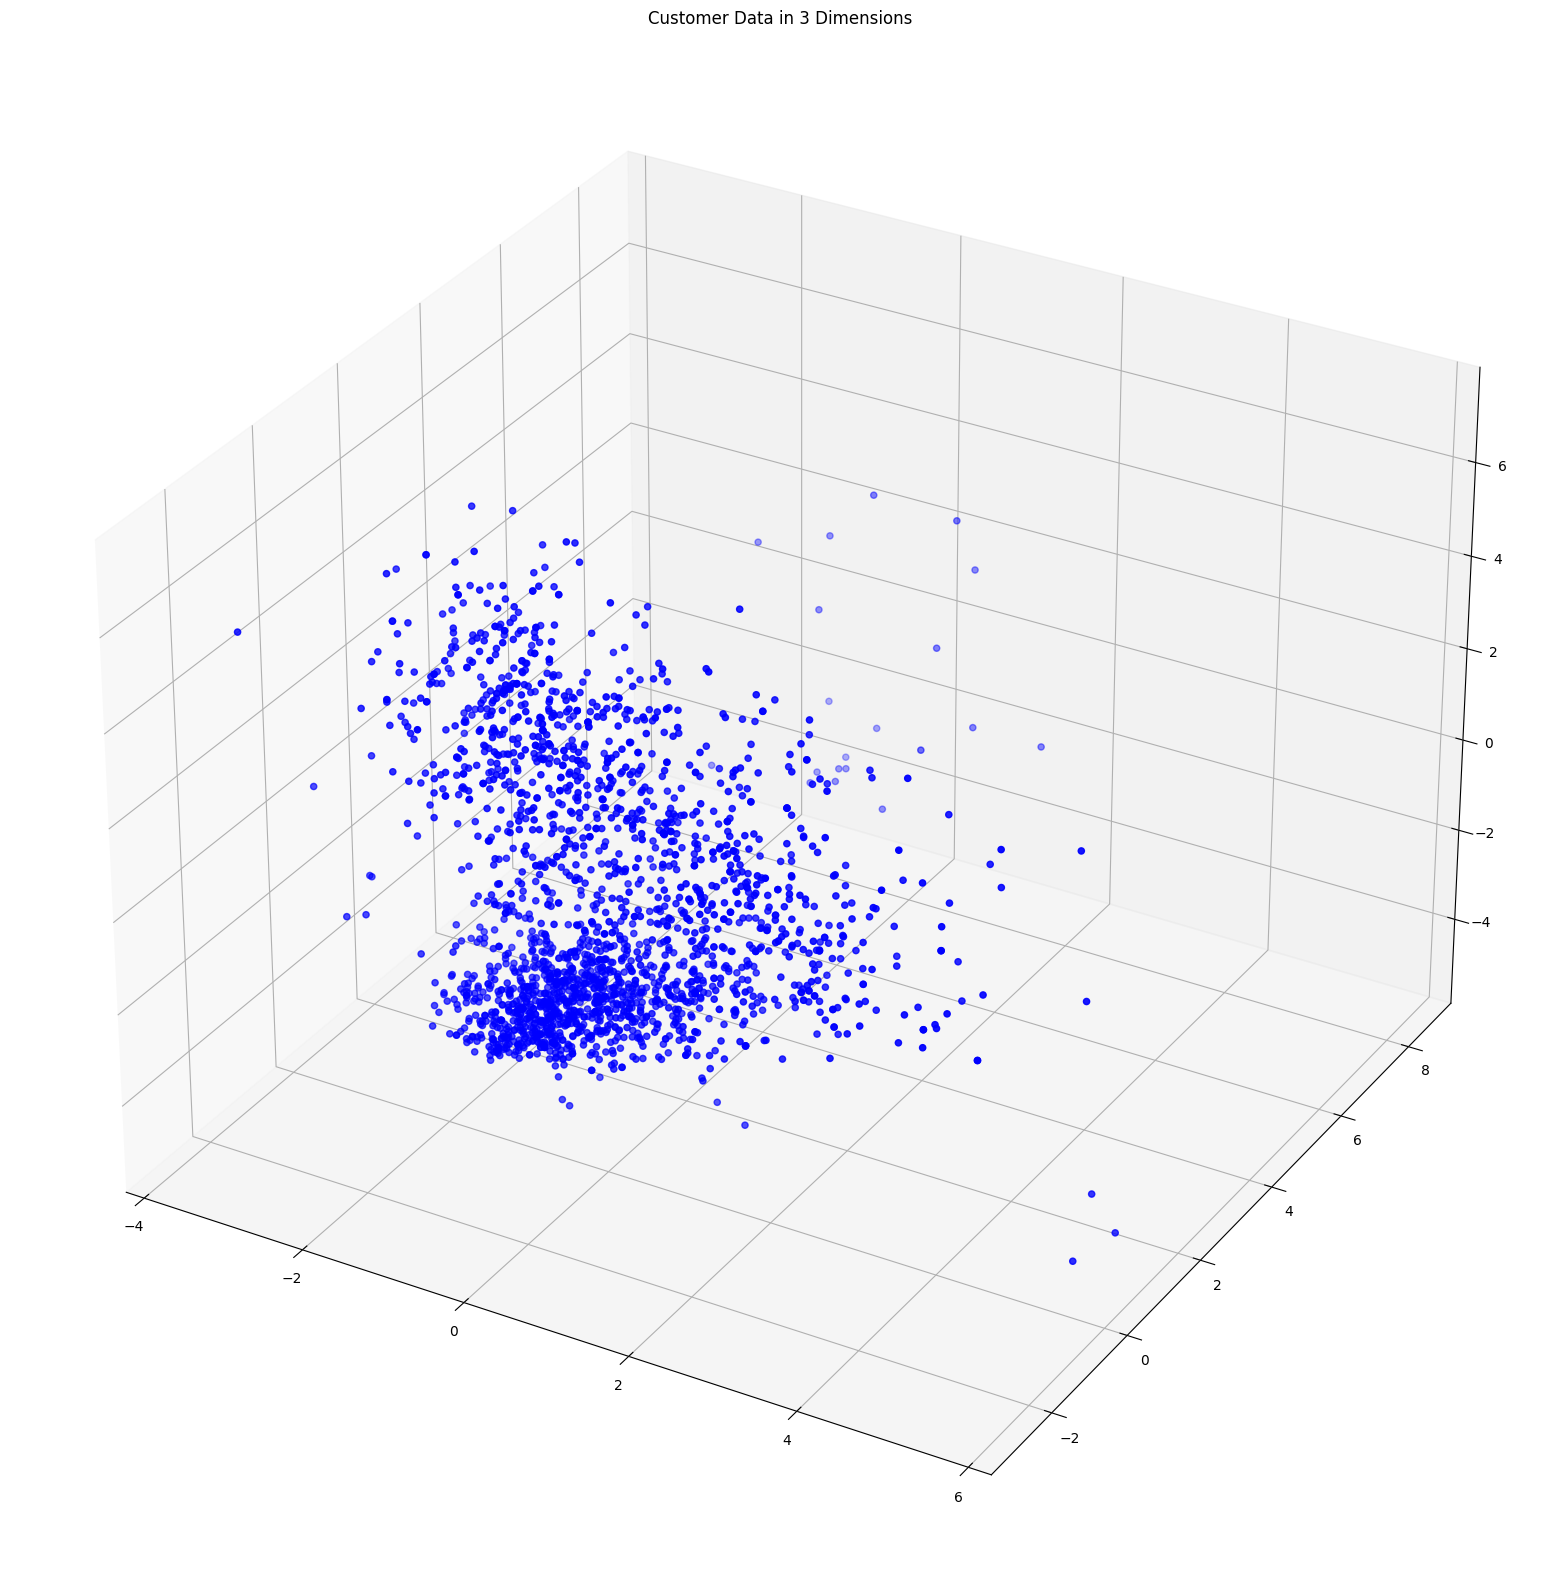

In [19]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], c="blue")
ax.set_title("Customer Data in 3 Dimensions")
plt.show()

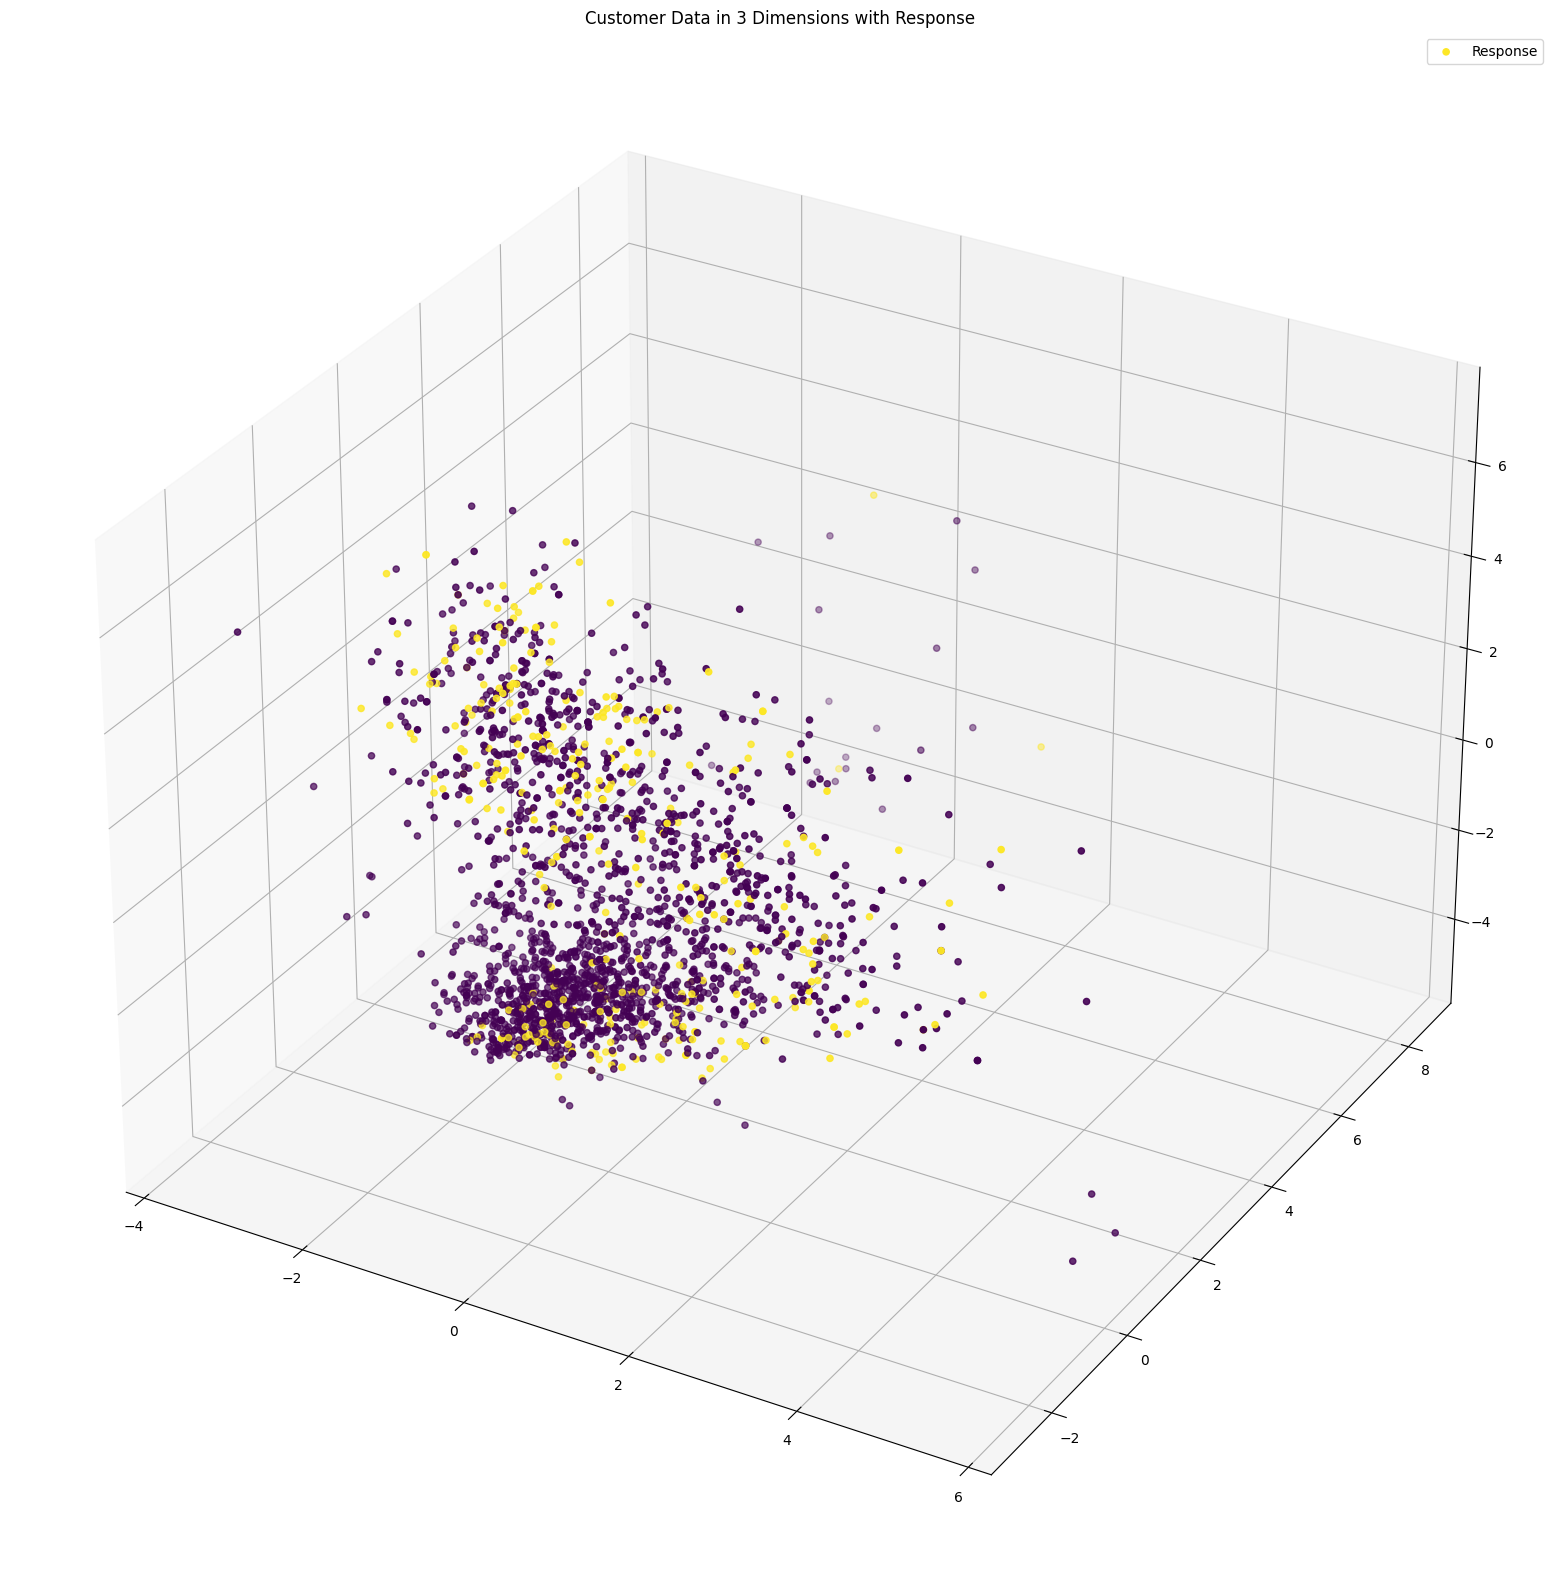

In [20]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], c=y)
ax.set_title("Customer Data in 3 Dimensions with Response")
ax.legend(['Response'])
plt.show()

After a first inspection, it looks like many of the customers who responded were located outside of the dense cluster that holds most customers.

### Customers clustering

In [30]:
#Create an instance of DBSCAN to create non spherical clusters based on data density
db = DBSCAN(eps=0.726, min_samples=50)

#fit to the dimentionality reduced dataset
db.fit(X_reduced)

#identify the clusters
clusters = db.labels_

#display metrics/sample
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Cluster Predictions')
print('-------------------------------')
print("Number of clusters: %d" % n_clusters_)
print("Number of noise points: %d" % n_noise_)
print('Number of points per cluster:')
for i in range(n_clusters_):
    print('Cluster', i, ':', len(clusters[clusters==i]))

Cluster Predictions
-------------------------------
Number of clusters: 2
Number of noise points: 965
Number of points per cluster:
Cluster 0 : 1073
Cluster 1 : 202


There are 2 distinct clusters of customers along with 965 outlier customers

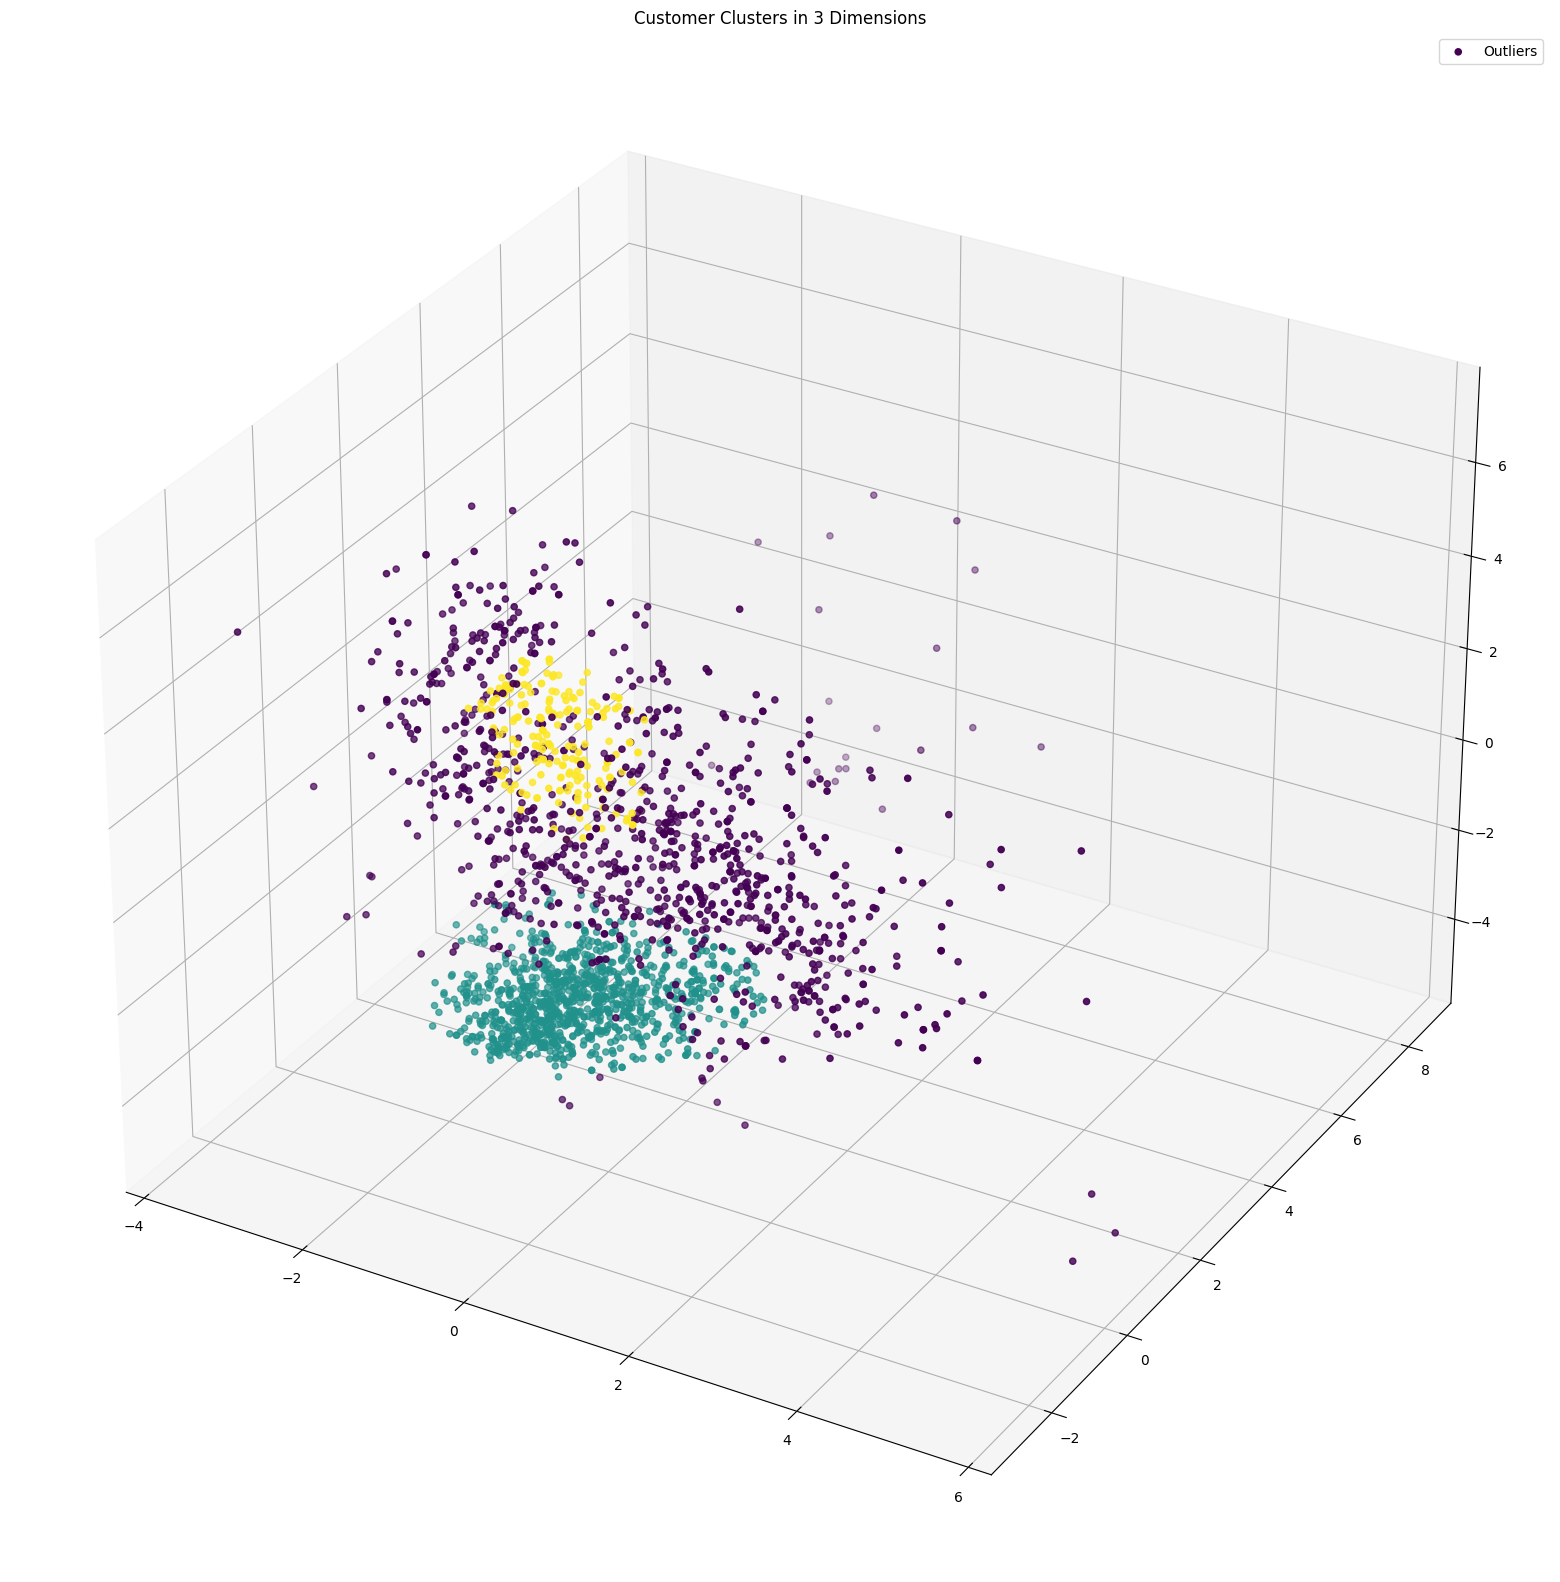

In [32]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], 
           c=clusters)
ax.set_title("Customer Clusters in 3 Dimensions")
ax.legend(['Outliers'])
plt.show()

In [33]:
customer_data['Cluster'] = clusters #append the clusters to the original dataset


#group by cluster and calculate how many responses there were per cluster
cluster_grp = customer_data.groupby('Cluster').Response.agg(['sum', 'count'])
cluster_grp['percent_resp'] = cluster_grp['sum'].values / cluster_grp['count'].values
cluster_grp

,sum,count,percent_resp
Cluster,,,
-1,190,965,0.196891
0,93,1073,0.086673
1,51,202,0.252475


### Data preparation for modelling

In [34]:
#Split into train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=8)

#Split the test set into 2 sets; 1 for test, 1 for validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=8)

#Display length of each set
print('Length of Each Dataset:')
print('Training Set:', len(X_train))
print('Validation Set:', len(X_val))
print('Test Set:', len(X_test))

Length of Each Dataset:
Training Set: 1568
Validation Set: 336
Test Set: 336


In [35]:
#Balance the training data set using SMOTE
sm = SMOTE(random_state=8)

#create new training set with SMOTE object
X_bal, y_bal = sm.fit_resample(X_train, y_train)

#Displays perccent of each class
print('Initial Training Set')
print('Percent "Responded":', y_train.sum()/len(y_train))
print('Balanced Training Set')
print('Percent "Responded":', y_bal.sum()/len(y_bal))

Initial Training Set
Percent "Responded": 0.14732142857142858
Balanced Training Set
Percent "Responded": 0.5


### ML modelling

We'll focus on **RECALL**, since we would rather have more False Positives (customers who will not respond to the marketing but was targeted anyway) than False Negatives (customers who would have responded to the add but were not targeted). 


- Logistic regression

In [36]:
log_params = {'solver': ['liblinear'], 'penalty': ['l1'], 'C': [1.0, 0.5, 0.25]}

#grid search
log_grid = GridSearchCV(LogisticRegression(), log_params, cv=3, scoring='recall')

#fit the grid to the training set that was balanced
log_grid.fit(X_bal, y_bal)

log = log_grid.best_estimator_

#Display Best Parameters
print('Best Parameters:', log_grid.best_params_)

#Display the metrics for the validation set
log_preds = log.predict(X_val)
log_val_acc = accuracy_score(y_val, log_preds)
log_val_rec = recall_score(y_val, log_preds)
print('Logistic Regression Model Accuracy:', log_val_acc)
print('Logistic Regression Model Recall:', log_val_rec)

Best Parameters: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Model Accuracy: 0.6934523809523809
Logistic Regression Model Recall: 0.7777777777777778


- SVM

In [37]:
#Params to test in grid search
svm_params = {'kernel': ['poly', 'rbf'], 'C': [1.0, 0.5, 0.25], 'gamma': ['scale', 'auto']}

#grid search
svm_grid = GridSearchCV(SVC(), svm_params, cv=3, scoring='recall')

#fit the grid to the training set that was balanced
svm_grid.fit(X_bal, y_bal)

svm = svm_grid.best_estimator_

#Display Best Parameters
print('Best Parameters:', svm_grid.best_params_)

#Display the metrics for the validation set
svm_preds = svm.predict(X_val)
svm_val_acc = accuracy_score(y_val, svm_preds)
svm_val_rec = recall_score(y_val, svm_preds)
print('Support Vector Machine Accuracy:', svm_val_acc)
print('Support Vector Machine Recall:', svm_val_rec)

Best Parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Support Vector Machine Accuracy: 0.7886904761904762
Support Vector Machine Recall: 0.7222222222222222


- K-nearest neighbours

In [38]:
#Params to test in grid search
knn_params = {'n_neighbors': [7, 9, 11], 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
             'weights': ['uniform', 'distance']}

#grid search
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, scoring='recall')

#fit the grid to the training set
knn_grid.fit(X_bal, y_bal)

knn = knn_grid.best_estimator_

#Display Best Parameters
print('Best Parameters:', knn_grid.best_params_)

#Display the metrics for the validation set
knn_preds = knn.predict(X_val)
knn_val_acc = accuracy_score(y_val, knn_preds)
knn_val_rec = recall_score(y_val, knn_preds)
print('K Nearest Neighbors Accuracy:', knn_val_acc)
print('K Nearest Neighbors Recall:', knn_val_rec)

Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'distance'}
K Nearest Neighbors Accuracy: 0.7083333333333334
K Nearest Neighbors Recall: 0.6296296296296297


- XGboost

In [41]:
#Params to test in grid search
xgb_params = {'n_estimators': [240, 250, 260], 'max_depth': [15, 16, 17],
             'colsample_bytree': [0.6, 0.7, 0.8, 1.0]}

#grid search
xgb_grid = GridSearchCV(XGBClassifier(verbosity=0), xgb_params, cv=3, 
                        scoring='recall')

#fit the grid to the training set
xgb_grid.fit(X_bal, y_bal)

#ID the best model
xgb = xgb_grid.best_estimator_

#Display Best Parameters
print('Best Parameters:', xgb_grid.best_params_)

#Display the metrics for the validation set
xgb_preds = xgb.predict(X_val)
xgb_val_acc = accuracy_score(y_val, xgb_preds)
xgb_val_rec = recall_score(y_val, xgb_preds)
print('Gradient Boosting Tree Accuracy:', xgb_val_acc)
print('Gradient Boosting Tree Recall:', xgb_val_rec)

Best Parameters: {'colsample_bytree': 0.8, 'max_depth': 15, 'n_estimators': 260}
Gradient Boosting Tree Accuracy: 0.8511904761904762
Gradient Boosting Tree Recall: 0.4444444444444444


- Ensamble methods

This model takes the predictions of the previous models and outputs the class with the highest amount of votes. We will not use the XGB because it may worsen the results. 

In [44]:
#Create ensemble model of all the other models
#list of models
models = [('logistic_regression', log), ('support vector machine', svm), 
        ('knn', knn)]

#Combine models
ensemble_model = VotingClassifier(estimators=models)

#fit the model on the training set
ensemble_model.fit(X_bal, y_bal)

#Display the metrics for the validation set
ensemble_preds = ensemble_model.predict(X_val)
ensemble_val_acc = accuracy_score(y_val, ensemble_preds)
ensemble_val_rec = recall_score(y_val, ensemble_preds)
print('Ensemble Model Accuracy:', ensemble_val_acc)
print('Ensemble Model Recall:', ensemble_val_rec)

Ensemble Model Accuracy: 0.7619047619047619
Ensemble Model Recall: 0.7222222222222222


In [45]:
#Display the metrics of the Ensemble model on the test set
test_preds = ensemble_model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
test_rec = recall_score(y_test, test_preds)
print('Test Set Metrics')
print('Ensemble Model Accuracy:', test_acc)
print('Ensemble Model Recall:', test_rec)

Test Set Metrics
Ensemble Model Accuracy: 0.8184523809523809
Ensemble Model Recall: 0.7959183673469388
